In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import cv2
import tensorflow as tf 
from tensorflow import keras
from pathlib import Path
from tqdm import tqdm
import PIL
import matplotlib.pyplot as plt
import os
print("Imported Successfully")


Imported Successfully


In [5]:
# import each path of the image classes
glaucoma = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\glaucoma')
cataract = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\cataract')
normal = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\normal')
diabetic_retinopathy = Path(r'C:\Users\swapn\OneDrive\Desktop\dataset\diabetic_retinopathy')

In [6]:
# create a dataframe with the file path and the labels
disease_type = [glaucoma, cataract,normal,diabetic_retinopathy]
df = pd.DataFrame()
from tqdm import tqdm
for types in disease_type:
    for imagepath in tqdm(list(types.iterdir()), desc= str(types)):
        df = pd.concat([df, pd.DataFrame({'image': [str(imagepath)],'disease_type': [disease_type.index(types)]})], ignore_index=True)

C:\Users\swapn\OneDrive\Desktop\dataset\normal: 100%|██████████| 1074/1074 [00:00<00:00, 2722.49it/s]
C:\Users\swapn\OneDrive\Desktop\dataset\diabetic_retinopathy: 100%|██████████| 1098/1098 [00:00<00:00, 2471.71it/s]


In [7]:
df

,image,disease_type
0,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
1,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
2,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
3,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
4,C:\Users\swapn\OneDrive\Desktop\dataset\glauco...,0
...,...,...
4385,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3
4386,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3
4387,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3
4388,C:\Users\swapn\OneDrive\Desktop\dataset\diabet...,3


In [8]:
df.disease_type.value_counts()

1    1211
3    1098
2    1074
0    1007
Name: disease_type, dtype: int64

In [9]:
# define function to plot sample images
def plot_image(n, num_samples=3):
    disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
    images = df[df['disease_type'] == n].sample(num_samples)['image']

    plt.figure(figsize=(12, 12))

    for i, path in enumerate(images, 1):
        img = (plt.imread(path) - plt.imread(path).min()) / plt.imread(path).max()
        plt.subplot(3, 3, i)
        plt.imshow(img)
        plt.axis('off')
        plt.title(disease_labels[n])

    plt.show()

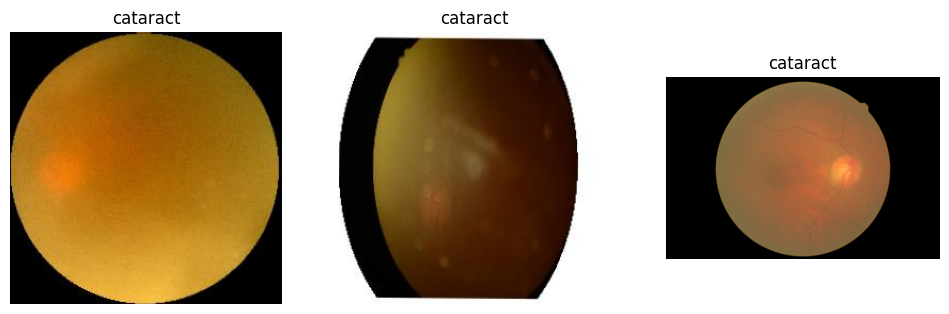

In [10]:
plot_image(1)

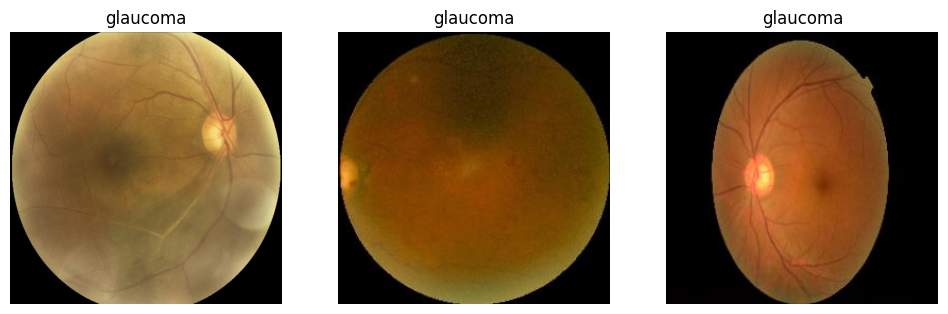

In [11]:
plot_image(0)

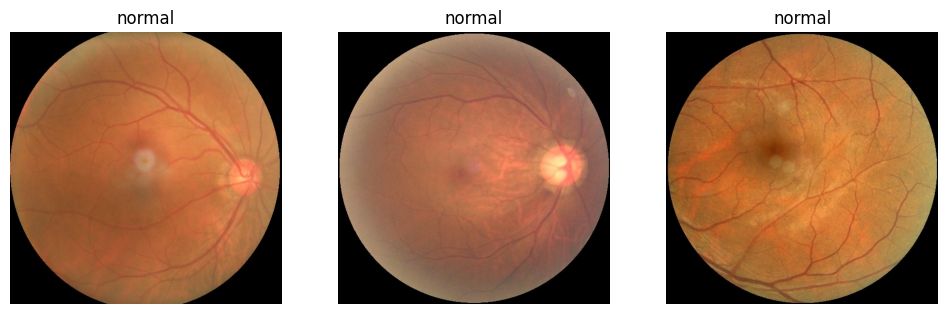

In [12]:
plot_image(2)

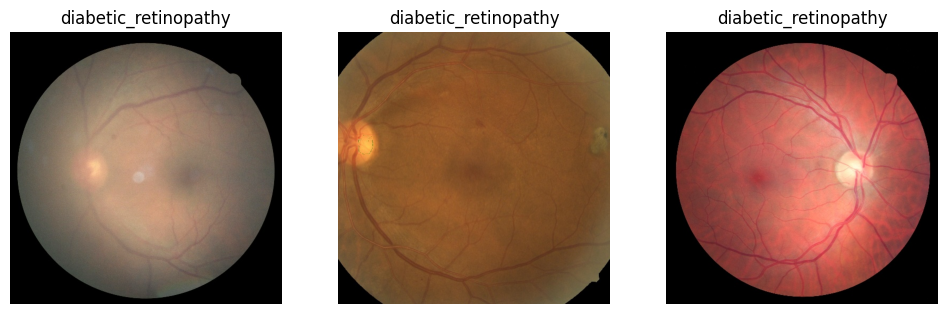

In [13]:
plot_image(3)

In [14]:
df['disease_type'] = df['disease_type'].map({0:'glaucoma',1:'cataract',2:'normal',3:'diabetic_retinopathy'})
# check the lebel count to verify it has been mapped
df.disease_type.value_counts()

cataract                1211
diabetic_retinopathy    1098
normal                  1074
glaucoma                1007
Name: disease_type, dtype: int64

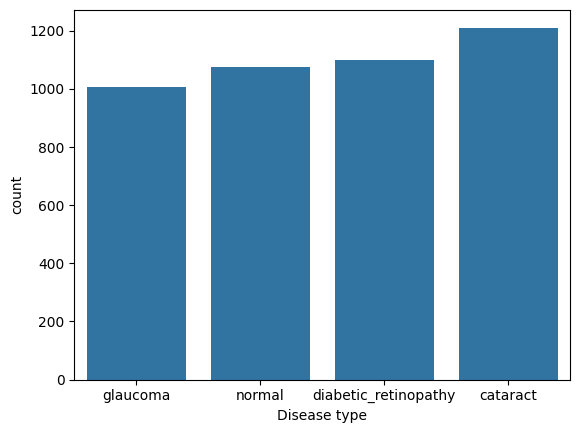

In [15]:
# randomising the dataset
df1 = df.sample(frac=1).reset_index(drop=True)
# create a countplot of the disease type
sns.countplot(x = 'disease_type', data = df1)
plt.xlabel("Disease type")
plt.show()

In [16]:
#import necessary libraries for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
# augumentation of images
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)
# create the train data
train_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          subset = 'training')

Found 3511 validated image filenames belonging to 4 classes.


c:\Users\swapn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [18]:
# create the validation data
valid_data = datagen.flow_from_dataframe(dataframe=df1,
                                          x_col ='image',
                                          y_col = 'disease_type',
                                          target_size=(224,224),
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = False,
                                          subset = 'validation')

Found 877 validated image filenames belonging to 4 classes.


c:\Users\swapn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [19]:
from tensorflow.keras.applications import DenseNet121
dense = DenseNet121(weights = "imagenet", include_top = False, input_shape=(224,224,3))

In [20]:
for layer in dense.layers[:121]:
    layer.trainable = False

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization

model = Sequential()
model.add(dense)
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation= "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "sigmoid"))

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 1024)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 3, 3, 1024)        4096      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 3, 3, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 512)               

In [23]:
patience = 1
stop_patience = 3
factor = 0.5
#tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1),
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("densenet121.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)]

In [24]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='cnn-plant.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
history = model.fit(train_data, validation_data = valid_data, epochs = 15)

Epoch 1/15


110/110 [==============================] - 675s 6s/step - loss: 1.2743 - accuracy: 0.6181 - val_loss: 11.2632 - val_accuracy: 0.3136
Epoch 2/15
110/110 [==============================] - 546s 5s/step - loss: 0.6006 - accuracy: 0.7813 - val_loss: 0.7024 - val_accuracy: 0.8107
Epoch 3/15
110/110 [==============================] - 749s 7s/step - loss: 0.5186 - accuracy: 0.8208 - val_loss: 0.7025 - val_accuracy: 0.8187
Epoch 4/15
110/110 [==============================] - 738s 7s/step - loss: 0.4719 - accuracy: 0.8357 - val_loss: 1.2056 - val_accuracy: 0.7389
Epoch 5/15
110/110 [==============================] - 714s 6s/step - loss: 0.4263 - accuracy: 0.8502 - val_loss: 1.0066 - val_accuracy: 0.7013
Epoch 6/15
110/110 [==============================] - 626s 6s/step - loss: 0.3860 - accuracy: 0.8624 - val_loss: 0.4338 - val_accuracy: 0.8597
Epoch 7/15
110/110 [==============================] - 666s 6s/step - loss: 0.3619 - accuracy: 0.8747 - val_loss: 1.0214 - val_accuracy: 0.7

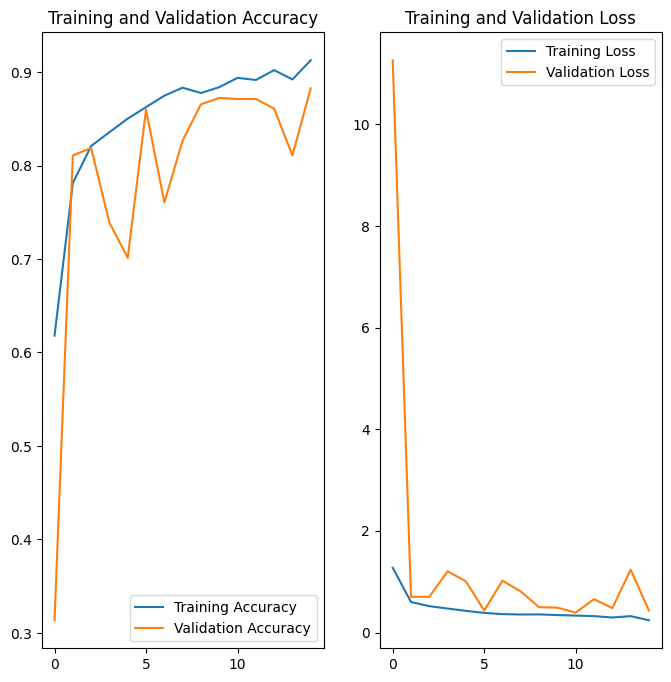

In [26]:
epochs=15
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
preformance = model.evaluate(valid_data)

28/28 [==============================] - 22s 782ms/step - loss: 0.4345 - accuracy: 0.8826


In [28]:
# evaluate the model
y_test = valid_data.classes
y_pred = model.predict(valid_data)
y_pred = np.argmax(y_pred,axis=1)


28/28 [==============================] - 25s 786ms/step


In [29]:

model.save("DensenetML.tf")


INFO:tensorflow:Assets written to: DensenetML.tf\assets


INFO:tensorflow:Assets written to: DensenetML.tf\assets


In [30]:

loaded_model = tf.keras.models.load_model('DensenetML.tf')


In [49]:

from tensorflow.keras.preprocessing import image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size based on your model requirements
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Provide the path to your image
image_path = r'C:\Users\swapn\OneDrive\Desktop\dataset\glaucoma\_19_6182574.jpg'  # Replace with the actual path to your image

# Preprocess the image
processed_image = preprocess_image(image_path)
predictions = loaded_model.predict(processed_image)
disease_labels = ['glaucoma', 'cataract', 'normal', 'diabetic_retinopathy']
df_predict = pd.DataFrame(predictions)
max_values_per_row = df_predict.idxmax(axis=1)
m = [disease_labels[i] for i in max_values_per_row]
print(m)

1/1 [==============================] - 0s 381ms/step
['glaucoma']


In [54]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

g_dict = valid_data.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(valid_data.classes, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

#plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(valid_data.classes, y_pred, target_names= classes))

                      precision    recall  f1-score   support

            cataract       0.95      0.79      0.86       217
diabetic_retinopathy       0.88      1.00      0.93       213
            glaucoma       0.91      0.78      0.84       207
              normal       0.83      0.95      0.88       240

            accuracy                           0.88       877
           macro avg       0.89      0.88      0.88       877
        weighted avg       0.89      0.88      0.88       877

